# Base XGBoost Model


# Load Packages


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
import xgboost as xgb
import optuna

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("All packages loaded successfully!")

All packages loaded successfully!


/Users/wmurray/Documents/Personal Work/class-imbalance-testing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data


In [2]:
df = pd.read_csv('../data/stroke_data_prepared.csv')
print(f"Dataset shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")
df.head()

Dataset shape: (5110, 17)
Features: ['id', 'age', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male', 'hypertension_Yes', 'heart_disease_Yes', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


,id,age,avg_glucose_level,bmi,stroke,gender_Male,hypertension_Yes,heart_disease_Yes,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,0.611111,3.712987,0.944444,1,1,0,1,1,0,1,0,0,1,1,0,0
1,51676,0.444444,2.994300,0.000000,1,0,0,0,1,0,0,1,0,0,0,1,0
2,31112,0.972222,0.380920,0.488889,1,1,0,1,1,0,1,0,0,0,0,1,0
3,60182,0.111111,2.153481,0.700000,1,0,0,0,1,0,1,0,0,1,0,0,1
4,1665,0.944444,2.231917,-0.455556,1,0,1,0,1,0,0,1,0,0,0,1,0


In [3]:
print("Target variable (stroke) distribution:")
print(df['stroke'].value_counts())
print(f"\nClass distribution:")
print(df['stroke'].value_counts(normalize=True))

Target variable (stroke) distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

Class distribution:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


# Data Preprocessing


In [4]:
X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {list(X.columns)}")


Feature matrix shape: (5110, 15)
Target vector shape: (5110,)
Features: ['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'hypertension_Yes', 'heart_disease_Yes', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training target distribution:")
print(y_train.value_counts(normalize=True))
print(f"Testing target distribution:")
print(y_test.value_counts(normalize=True))


Training set shape: (4088, 15)
Testing set shape: (1022, 15)
Training target distribution:
stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
Testing target distribution:
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


# Scaled Positive Weight XGBoost Model


In [6]:
pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

base_model = xgb.XGBClassifier(
    tree_method='hist', 
    eval_metric='aucpr',  
    random_state=42,
    scale_pos_weight=pos_class_weight
)

print("Base XGBoost model created with default settings")
print("Key settings:")
print(f"  - Tree method: {base_model.tree_method}")
print(f"  - Eval metric: {base_model.eval_metric}")
print(f"  - Objective: {base_model.objective}")
print("\nFull model parameters:")
print(base_model.get_params())

Base XGBoost model created with default settings
Key settings:
  - Tree method: hist
  - Eval metric: aucpr
  - Objective: binary:logistic

Full model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'aucpr', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': np.fl

In [7]:
print("Training base XGBoost model...")
base_model.fit(X_train, y_train)
print("Model training completed!")

Training base XGBoost model...
Model training completed!


# Model Evaluation


In [8]:
y_pred = base_model.predict(X_test)
y_pred_proba = base_model.predict_proba(X_test)[:, 1]

print("Predictions completed!")

Predictions completed!


In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)

print("Base Model Performance Metrics:")
print("="*45)
print(f"AUPRC (PRIMARY METRIC): {auprc:.4f}")
print("="*45)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

Base Model Performance Metrics:
AUPRC (PRIMARY METRIC): 0.1816
Accuracy:  0.9237
Precision: 0.1957
Recall:    0.1800
F1-Score:  0.1875
ROC-AUC:   0.8052


In [10]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.20      0.18      0.19        50

    accuracy                           0.92      1022
   macro avg       0.58      0.57      0.57      1022
weighted avg       0.92      0.92      0.92      1022



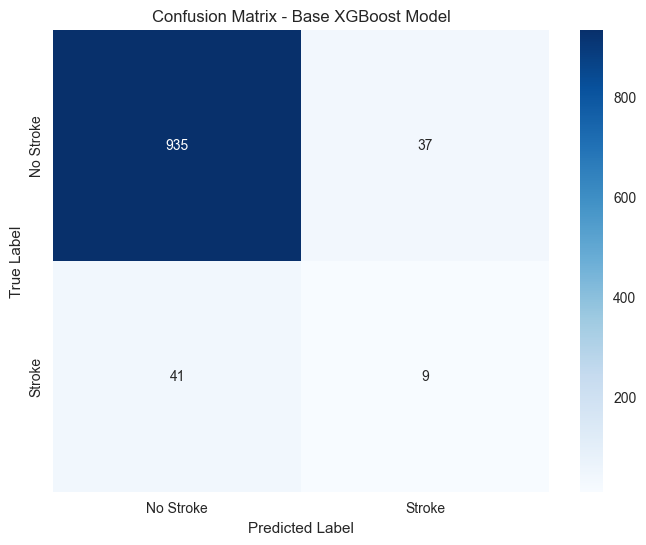

In [11]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Stroke', 'Stroke'], 
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix - Base XGBoost Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

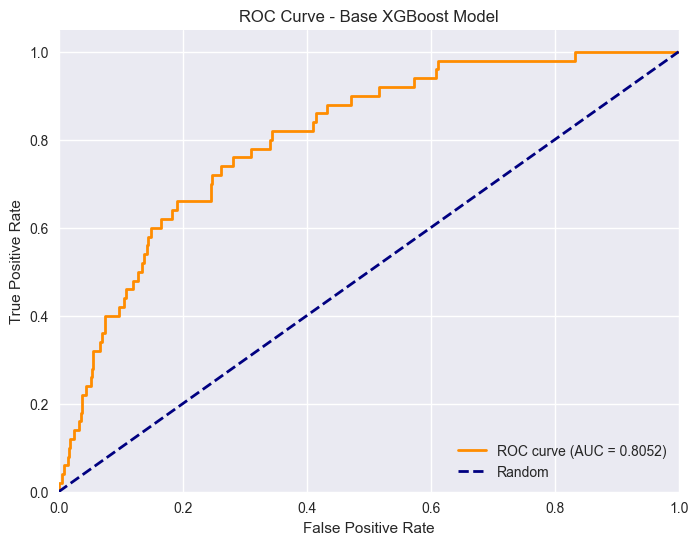

In [12]:
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Base XGBoost Model')
plt.legend(loc="lower right")
plt.show()

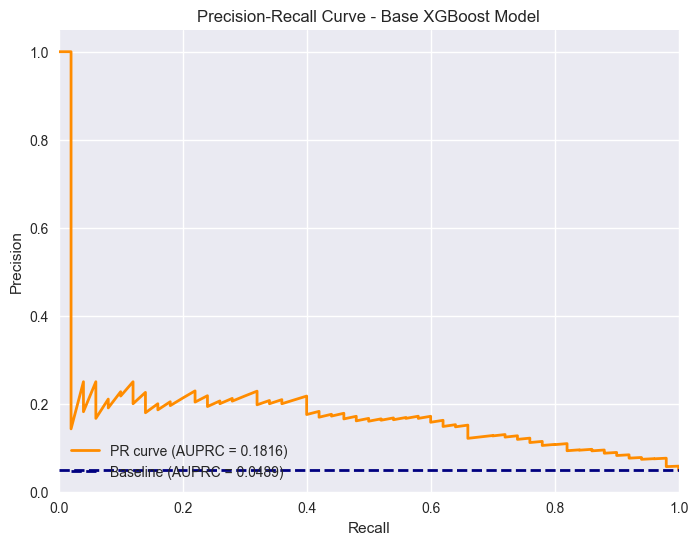

In [13]:
plt.figure(figsize=(8, 6))
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve, color='darkorange', lw=2, 
         label=f'PR curve (AUPRC = {auprc:.4f})')

baseline = y_test.mean()
plt.axhline(y=baseline, color='navy', lw=2, linestyle='--', 
           label=f'Baseline (AUPRC = {baseline:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Base XGBoost Model')
plt.legend(loc="lower left")
plt.show()

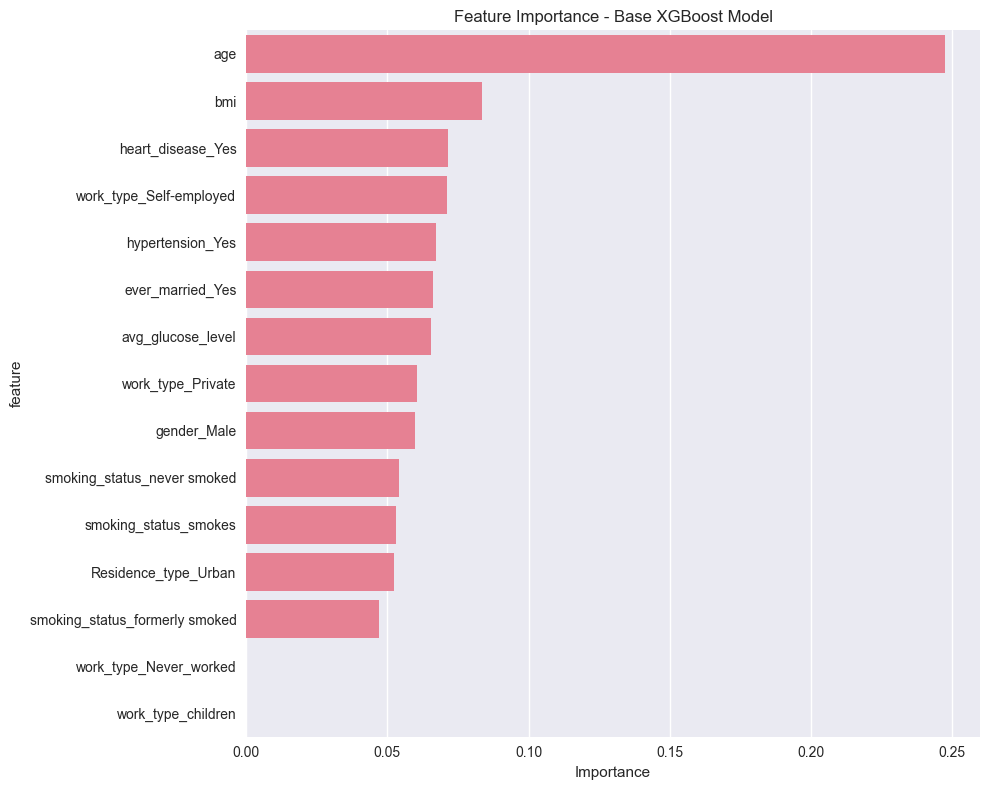

Top 5 Most Important Features:
                   feature  importance
0                      age    0.247526
2                      bmi    0.083643
5        heart_disease_Yes    0.071315
9  work_type_Self-employed    0.071279
4         hypertension_Yes    0.067398


In [14]:
plt.figure(figsize=(10, 8))
feature_importance = base_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance - Base XGBoost Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
print(importance_df.head())


# Summary


In [15]:
print("Scaled Positive Weight XGBoost Model Summary:")
print("="*50)
print(f"Dataset: Stroke Prediction ({X.shape[0]:,} samples, {X.shape[1]} features)")
print(f"Class Distribution: {(1-y.mean())*100:.1f}% No Stroke, {y.mean()*100:.1f}% Stroke")
print(f"Train/Test Split: {len(X_train):,} / {len(X_test):,}")
print()
print("Performance Metrics:")
print(f"  - AUPRC (PRIMARY): {auprc:.4f}")
print(f"  - Baseline AUPRC:  {y.mean():.4f}")
print(f"  - Accuracy:        {accuracy:.4f}")
print(f"  - Precision:       {precision:.4f}")
print(f"  - Recall:          {recall:.4f}")
print(f"  - F1-Score:        {f1:.4f}")
print(f"  - ROC-AUC:         {roc_auc:.4f}")

Scaled Positive Weight XGBoost Model Summary:
Dataset: Stroke Prediction (5,110 samples, 15 features)
Class Distribution: 95.1% No Stroke, 4.9% Stroke
Train/Test Split: 4,088 / 1,022

Performance Metrics:
  - AUPRC (PRIMARY): 0.1816
  - Baseline AUPRC:  0.0487
  - Accuracy:        0.9237
  - Precision:       0.1957
  - Recall:          0.1800
  - F1-Score:        0.1875
  - ROC-AUC:         0.8052


# Optuna Hyperparameter Tuning for scale_pos_weight


In [16]:
X_train_opt, X_val, y_train_opt, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Optimization training set shape: {X_train_opt.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape (unchanged): {X_test.shape}")

Optimization training set shape: (3270, 15)
Validation set shape: (818, 15)
Test set shape (unchanged): (1022, 15)


In [17]:
def objective(trial):
    scale_pos_weight = trial.suggest_float(
        'scale_pos_weight', 
        pos_class_weight * 0.5,
        pos_class_weight * 2.0,
        log=True
    )
    
    model = xgb.XGBClassifier(
        tree_method='hist',
        eval_metric='aucpr',
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )
    
    model.fit(X_train_opt, y_train_opt)
    
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    auprc = average_precision_score(y_val, y_val_pred_proba)
    
    return auprc

print("Objective function defined!")
print(f"Search range: {pos_class_weight * 0.5:.2f} to {pos_class_weight * 2.0:.2f}")
print(f"Centered around calculated value: {pos_class_weight:.2f}")


Objective function defined!
Search range: 9.77 to 39.09
Centered around calculated value: 19.54


In [18]:
print("Starting Optuna hyperparameter optimization...")
print(f"Calculated scale_pos_weight (class ratio): {pos_class_weight:.4f}")
print(f"Search range: [{pos_class_weight * 0.1:.4f}, {pos_class_weight * 5.0:.4f}]")
print("="*60)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', study_name='scale_pos_weight_optimization', sampler=sampler)

study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nOptimization completed!")
print("="*60)
print(f"Best AUPRC: {study.best_value:.4f}")
print(f"Best scale_pos_weight: {study.best_params['scale_pos_weight']:.4f}")
print(f"Calculated scale_pos_weight: {pos_class_weight:.4f}")
print(f"Ratio (optimal/calculated): {study.best_params['scale_pos_weight'] / pos_class_weight:.2f}x")


[I 2025-10-20 15:50:10,686] A new study created in memory with name: scale_pos_weight_optimization


Starting Optuna hyperparameter optimization...
Calculated scale_pos_weight (class ratio): 19.5427
Search range: [1.9543, 97.7136]


Best trial: 1. Best value: 0.13183:   4%|▍         | 2/50 [00:00<00:03, 14.32it/s] 

[I 2025-10-20 15:50:10,766] Trial 0 finished with value: 0.1255963397767619 and parameters: {'scale_pos_weight': 16.422924327706333}. Best is trial 0 with value: 0.1255963397767619.
[I 2025-10-20 15:50:10,832] Trial 1 finished with value: 0.1318300619461202 and parameters: {'scale_pos_weight': 36.504122918603294}. Best is trial 1 with value: 0.1318300619461202.


Best trial: 2. Best value: 0.140429:   4%|▍         | 2/50 [00:00<00:03, 14.32it/s]

[I 2025-10-20 15:50:10,879] Trial 2 finished with value: 0.14042886201895313 and parameters: {'scale_pos_weight': 26.956229010911354}. Best is trial 2 with value: 0.14042886201895313.


Best trial: 2. Best value: 0.140429:   6%|▌         | 3/50 [00:00<00:03, 14.32it/s]

[I 2025-10-20 15:50:10,923] Trial 3 finished with value: 0.12664066189606046 and parameters: {'scale_pos_weight': 22.406973105055442}. Best is trial 2 with value: 0.14042886201895313.


Best trial: 6. Best value: 0.148487:  12%|█▏        | 6/50 [00:00<00:02, 18.90it/s]

[I 2025-10-20 15:50:10,967] Trial 4 finished with value: 0.1366073944513454 and parameters: {'scale_pos_weight': 12.130744409285239}. Best is trial 2 with value: 0.14042886201895313.
[I 2025-10-20 15:50:11,010] Trial 5 finished with value: 0.1366073944513454 and parameters: {'scale_pos_weight': 12.130338793484565}. Best is trial 2 with value: 0.14042886201895313.
[I 2025-10-20 15:50:11,054] Trial 6 finished with value: 0.1484865771671523 and parameters: {'scale_pos_weight': 10.590700586410573}. Best is trial 6 with value: 0.1484865771671523.


Best trial: 7. Best value: 0.155247:  16%|█▌        | 8/50 [00:00<00:02, 20.90it/s]

[I 2025-10-20 15:50:11,095] Trial 7 finished with value: 0.15524734315930636 and parameters: {'scale_pos_weight': 32.467202809889635}. Best is trial 7 with value: 0.15524734315930636.


Best trial: 7. Best value: 0.155247:  16%|█▌        | 8/50 [00:00<00:02, 20.90it/s]

[I 2025-10-20 15:50:11,145] Trial 8 finished with value: 0.13980426015704847 and parameters: {'scale_pos_weight': 22.483409463148146}. Best is trial 7 with value: 0.15524734315930636.


Best trial: 7. Best value: 0.155247:  22%|██▏       | 11/50 [00:00<00:01, 20.78it/s]

[I 2025-10-20 15:50:11,193] Trial 9 finished with value: 0.12401547222885882 and parameters: {'scale_pos_weight': 26.076964821277738}. Best is trial 7 with value: 0.15524734315930636.
[I 2025-10-20 15:50:11,241] Trial 10 finished with value: 0.13600195893215344 and parameters: {'scale_pos_weight': 37.95581691719405}. Best is trial 7 with value: 0.15524734315930636.
[I 2025-10-20 15:50:11,286] Trial 11 finished with value: 0.13716425071980795 and parameters: {'scale_pos_weight': 10.298186372168084}. Best is trial 7 with value: 0.15524734315930636.


Best trial: 7. Best value: 0.155247:  24%|██▍       | 12/50 [00:00<00:01, 20.78it/s]

[I 2025-10-20 15:50:11,331] Trial 12 finished with value: 0.15046020855249378 and parameters: {'scale_pos_weight': 15.172798273837033}. Best is trial 7 with value: 0.15524734315930636.


Best trial: 7. Best value: 0.155247:  28%|██▊       | 14/50 [00:00<00:01, 21.11it/s]

[I 2025-10-20 15:50:11,379] Trial 13 finished with value: 0.1395257663786558 and parameters: {'scale_pos_weight': 16.548263115343044}. Best is trial 7 with value: 0.15524734315930636.


Best trial: 15. Best value: 0.155386:  34%|███▍      | 17/50 [00:00<00:01, 20.92it/s]

[I 2025-10-20 15:50:11,428] Trial 14 finished with value: 0.12066696761736885 and parameters: {'scale_pos_weight': 16.38071667837587}. Best is trial 7 with value: 0.15524734315930636.
[I 2025-10-20 15:50:11,472] Trial 15 finished with value: 0.15538613922547423 and parameters: {'scale_pos_weight': 30.608736873063812}. Best is trial 15 with value: 0.15538613922547423.
[I 2025-10-20 15:50:11,525] Trial 16 finished with value: 0.13125038062585312 and parameters: {'scale_pos_weight': 31.417604491985564}. Best is trial 15 with value: 0.15538613922547423.


Best trial: 15. Best value: 0.155386:  34%|███▍      | 17/50 [00:00<00:01, 20.92it/s]

[I 2025-10-20 15:50:11,582] Trial 17 finished with value: 0.13267348848870997 and parameters: {'scale_pos_weight': 30.413149690188185}. Best is trial 15 with value: 0.15538613922547423.


Best trial: 15. Best value: 0.155386:  40%|████      | 20/50 [00:01<00:01, 19.59it/s]

[I 2025-10-20 15:50:11,637] Trial 18 finished with value: 0.13825696684363747 and parameters: {'scale_pos_weight': 32.73404287565398}. Best is trial 15 with value: 0.15538613922547423.
[I 2025-10-20 15:50:11,697] Trial 19 finished with value: 0.1226499353478636 and parameters: {'scale_pos_weight': 20.995221455054363}. Best is trial 15 with value: 0.15538613922547423.
[I 2025-10-20 15:50:11,760] Trial 20 finished with value: 0.12738743772238464 and parameters: {'scale_pos_weight': 26.20587849383063}. Best is trial 15 with value: 0.15538613922547423.


Best trial: 15. Best value: 0.155386:  44%|████▍     | 22/50 [00:01<00:01, 19.17it/s]

[I 2025-10-20 15:50:11,809] Trial 21 finished with value: 0.13026929779914526 and parameters: {'scale_pos_weight': 13.989318667261788}. Best is trial 15 with value: 0.15538613922547423.


Best trial: 15. Best value: 0.155386:  50%|█████     | 25/50 [00:01<00:01, 19.94it/s]

[I 2025-10-20 15:50:11,859] Trial 22 finished with value: 0.1462640477043292 and parameters: {'scale_pos_weight': 18.6567762665477}. Best is trial 15 with value: 0.15538613922547423.
[I 2025-10-20 15:50:11,904] Trial 23 finished with value: 0.1492761951269276 and parameters: {'scale_pos_weight': 18.447001905846182}. Best is trial 15 with value: 0.15538613922547423.
[I 2025-10-20 15:50:11,948] Trial 24 finished with value: 0.12829192830916233 and parameters: {'scale_pos_weight': 14.055877875236046}. Best is trial 15 with value: 0.15538613922547423.


Best trial: 15. Best value: 0.155386:  54%|█████▍    | 27/50 [00:01<00:01, 19.57it/s]

[I 2025-10-20 15:50:12,014] Trial 25 finished with value: 0.14785188708048072 and parameters: {'scale_pos_weight': 28.620719193486266}. Best is trial 15 with value: 0.15538613922547423.
[I 2025-10-20 15:50:12,055] Trial 26 finished with value: 0.13488307462487514 and parameters: {'scale_pos_weight': 34.76999537797008}. Best is trial 15 with value: 0.15538613922547423.


Best trial: 15. Best value: 0.155386:  58%|█████▊    | 29/50 [00:01<00:01, 19.66it/s]

[I 2025-10-20 15:50:12,104] Trial 27 finished with value: 0.1310814598176712 and parameters: {'scale_pos_weight': 23.858113317979498}. Best is trial 15 with value: 0.15538613922547423.
[I 2025-10-20 15:50:12,156] Trial 28 finished with value: 0.12141326678034858 and parameters: {'scale_pos_weight': 14.148145391559716}. Best is trial 15 with value: 0.15538613922547423.


Best trial: 15. Best value: 0.155386:  62%|██████▏   | 31/50 [00:01<00:01, 18.70it/s]

[I 2025-10-20 15:50:12,221] Trial 29 finished with value: 0.1395257663786558 and parameters: {'scale_pos_weight': 16.54751739776527}. Best is trial 15 with value: 0.15538613922547423.
[I 2025-10-20 15:50:12,277] Trial 30 finished with value: 0.13931714778756982 and parameters: {'scale_pos_weight': 33.498493011550224}. Best is trial 15 with value: 0.15538613922547423.


Best trial: 32. Best value: 0.161639:  66%|██████▌   | 33/50 [00:01<00:00, 18.92it/s]

[I 2025-10-20 15:50:12,331] Trial 31 finished with value: 0.1283309706925861 and parameters: {'scale_pos_weight': 20.309976777653663}. Best is trial 15 with value: 0.15538613922547423.
[I 2025-10-20 15:50:12,379] Trial 32 finished with value: 0.16163947587774213 and parameters: {'scale_pos_weight': 18.17423632101918}. Best is trial 32 with value: 0.16163947587774213.


Best trial: 32. Best value: 0.161639:  66%|██████▌   | 33/50 [00:01<00:00, 18.92it/s]

[I 2025-10-20 15:50:12,500] Trial 33 finished with value: 0.13272847621319608 and parameters: {'scale_pos_weight': 17.496116028202803}. Best is trial 32 with value: 0.16163947587774213.


Best trial: 32. Best value: 0.161639:  74%|███████▍  | 37/50 [00:01<00:00, 16.29it/s]

[I 2025-10-20 15:50:12,571] Trial 34 finished with value: 0.13206001529177472 and parameters: {'scale_pos_weight': 38.216607102433734}. Best is trial 32 with value: 0.16163947587774213.
[I 2025-10-20 15:50:12,621] Trial 35 finished with value: 0.1382774322502261 and parameters: {'scale_pos_weight': 24.25115070522705}. Best is trial 32 with value: 0.16163947587774213.
[I 2025-10-20 15:50:12,676] Trial 36 finished with value: 0.14925675114290685 and parameters: {'scale_pos_weight': 28.49067834101174}. Best is trial 32 with value: 0.16163947587774213.


[I 2025-10-20 15:50:12,723] Trial 37 finished with value: 0.15047335468898107 and parameters: {'scale_pos_weight': 15.227439196663958}. Best is trial 32 with value: 0.16163947587774213.


Best trial: 32. Best value: 0.161639:  80%|████████  | 40/50 [00:02<00:00, 16.84it/s]

[I 2025-10-20 15:50:12,771] Trial 38 finished with value: 0.1371167239413215 and parameters: {'scale_pos_weight': 12.388818450433531}. Best is trial 32 with value: 0.16163947587774213.
[I 2025-10-20 15:50:12,844] Trial 39 finished with value: 0.1380918849345544 and parameters: {'scale_pos_weight': 21.695423302644173}. Best is trial 32 with value: 0.16163947587774213.
[I 2025-10-20 15:50:12,912] Trial 40 finished with value: 0.13840611001421602 and parameters: {'scale_pos_weight': 18.86070412691397}. Best is trial 32 with value: 0.16163947587774213.


Best trial: 32. Best value: 0.161639:  84%|████████▍ | 42/50 [00:02<00:00, 17.03it/s]

[I 2025-10-20 15:50:12,958] Trial 41 finished with value: 0.1431511616706931 and parameters: {'scale_pos_weight': 14.637300269539754}. Best is trial 32 with value: 0.16163947587774213.


Best trial: 32. Best value: 0.161639:  90%|█████████ | 45/50 [00:02<00:00, 18.33it/s]

[I 2025-10-20 15:50:13,006] Trial 42 finished with value: 0.1304179629998142 and parameters: {'scale_pos_weight': 15.575809408769954}. Best is trial 32 with value: 0.16163947587774213.
[I 2025-10-20 15:50:13,055] Trial 43 finished with value: 0.13363347999775133 and parameters: {'scale_pos_weight': 12.945947203458887}. Best is trial 32 with value: 0.16163947587774213.
[I 2025-10-20 15:50:13,100] Trial 44 finished with value: 0.12876085508756552 and parameters: {'scale_pos_weight': 15.482919875693556}. Best is trial 32 with value: 0.16163947587774213.
[I 2025-10-20 15:50:13,145] Trial 45 finished with value: 0.12630044468681637 and parameters: {'scale_pos_weight': 11.336542101225872}. Best is trial 32 with value: 0.16163947587774213.


Best trial: 32. Best value: 0.161639:  92%|█████████▏| 46/50 [00:02<00:00, 18.33it/s]

[I 2025-10-20 15:50:13,190] Trial 46 finished with value: 0.1350657971068376 and parameters: {'scale_pos_weight': 17.77388929685988}. Best is trial 32 with value: 0.16163947587774213.


Best trial: 32. Best value: 0.161639: 100%|██████████| 50/50 [00:02<00:00, 18.98it/s]

[I 2025-10-20 15:50:13,236] Trial 47 finished with value: 0.153115566565163 and parameters: {'scale_pos_weight': 13.029875850308045}. Best is trial 32 with value: 0.16163947587774213.
[I 2025-10-20 15:50:13,281] Trial 48 finished with value: 0.153115566565163 and parameters: {'scale_pos_weight': 13.029665252187094}. Best is trial 32 with value: 0.16163947587774213.
[I 2025-10-20 15:50:13,327] Trial 49 finished with value: 0.12399683572171065 and parameters: {'scale_pos_weight': 9.821088255606945}. Best is trial 32 with value: 0.16163947587774213.

Optimization completed!
Best AUPRC: 0.1616
Best scale_pos_weight: 18.1742
Calculated scale_pos_weight: 19.5427
Ratio (optimal/calculated): 0.93x


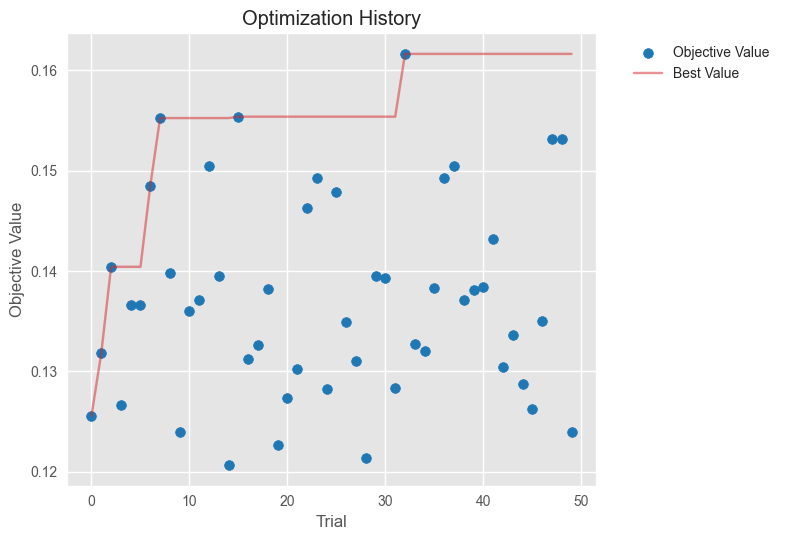

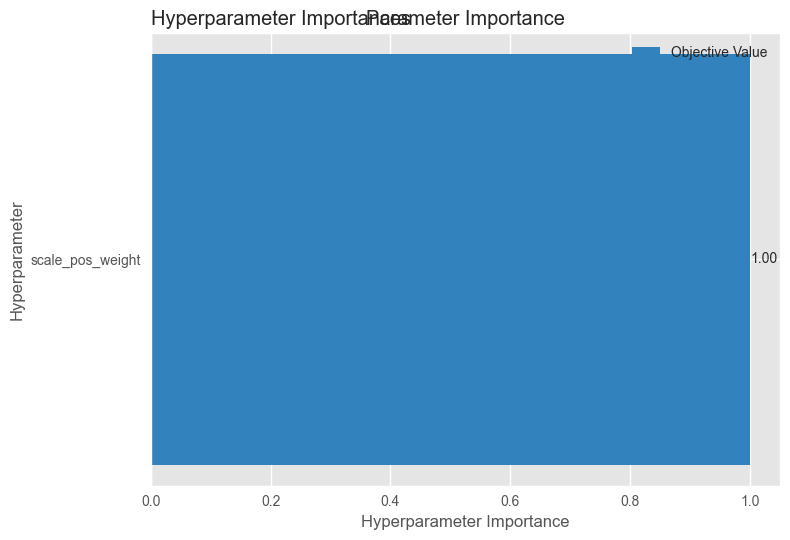

In [19]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.tight_layout()
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Parameter Importance')
plt.tight_layout()
plt.show()


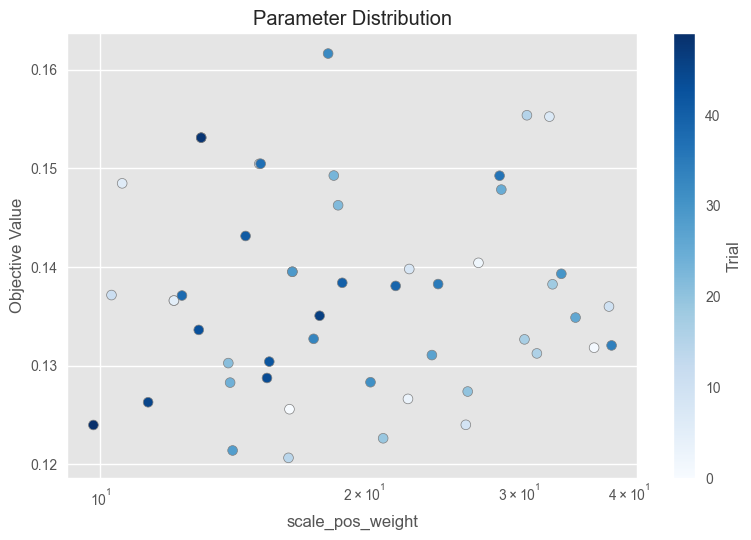

In [20]:
optuna.visualization.matplotlib.plot_slice(study)
plt.title('Parameter Distribution')
plt.tight_layout()
plt.show()

# Train Final Model with Optimized scale_pos_weight


In [21]:
optimized_model = xgb.XGBClassifier(
    tree_method='hist',
    eval_metric='aucpr',
    random_state=42,
    scale_pos_weight=study.best_params['scale_pos_weight']
)

print("Training optimized XGBoost model on full training set...")
optimized_model.fit(X_train, y_train)
print("Model training completed!")

Training optimized XGBoost model on full training set...
Model training completed!


In [22]:
y_pred_opt = optimized_model.predict(X_test)
y_pred_proba_opt = optimized_model.predict_proba(X_test)[:, 1]

accuracy_opt = accuracy_score(y_test, y_pred_opt)
precision_opt = precision_score(y_test, y_pred_opt)
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)
roc_auc_opt = roc_auc_score(y_test, y_pred_proba_opt)
auprc_opt = average_precision_score(y_test, y_pred_proba_opt)

print("Optimized Model Performance Metrics:")
print("="*45)
print(f"AUPRC (PRIMARY METRIC): {auprc_opt:.4f}")
print("="*45)
print(f"Accuracy:  {accuracy_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall:    {recall_opt:.4f}")
print(f"F1-Score:  {f1_opt:.4f}")
print(f"ROC-AUC:   {roc_auc_opt:.4f}")

Optimized Model Performance Metrics:
AUPRC (PRIMARY METRIC): 0.1692
Accuracy:  0.9247
Precision: 0.1707
Recall:    0.1400
F1-Score:  0.1538
ROC-AUC:   0.7852


# Model Comparison


In [23]:
comparison_df = pd.DataFrame({
    'Metric': ['AUPRC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Base Model': [auprc, accuracy, precision, recall, f1, roc_auc],
    'Optimized Model': [auprc_opt, accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt],
})
comparison_df['Improvement'] = comparison_df['Optimized Model'] - comparison_df['Base Model']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Base Model']) * 100

print("Model Comparison:")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)
print(f"\nBase scale_pos_weight (calculated): {pos_class_weight:.4f}")
print(f"Optimized scale_pos_weight: {study.best_params['scale_pos_weight']:.4f}")

Model Comparison:
   Metric  Base Model  Optimized Model  Improvement  Improvement %
    AUPRC    0.181619         0.169155    -0.012464      -6.862847
 Accuracy    0.923679         0.924658     0.000978       0.105932
Precision    0.195652         0.170732    -0.024920     -12.737127
   Recall    0.180000         0.140000    -0.040000     -22.222222
 F1-Score    0.187500         0.153846    -0.033654     -17.948718
  ROC-AUC    0.805247         0.785247    -0.020000      -2.483710

Base scale_pos_weight (calculated): 19.5427
Optimized scale_pos_weight: 18.1742


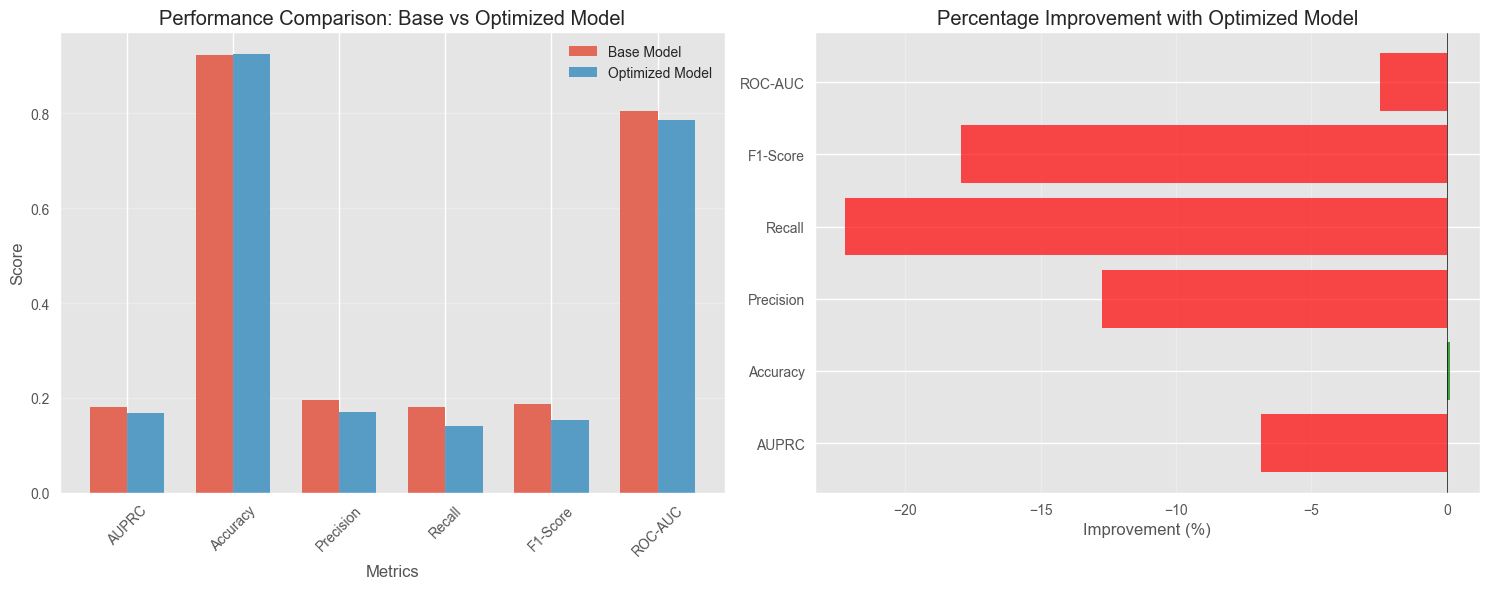

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

metrics = ['AUPRC', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
base_scores = [auprc, accuracy, precision, recall, f1, roc_auc]
opt_scores = [auprc_opt, accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, base_scores, width, label='Base Model', alpha=0.8)
axes[0].bar(x + width/2, opt_scores, width, label='Optimized Model', alpha=0.8)
axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Comparison: Base vs Optimized Model')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

improvements = comparison_df['Improvement %'].values
colors = ['green' if imp > 0 else 'red' for imp in improvements]
axes[1].barh(metrics, improvements, color=colors, alpha=0.7)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Improvement (%)')
axes[1].set_title('Percentage Improvement with Optimized Model')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
print("Classification Report (Optimized Model):")
print(classification_report(y_test, y_pred_opt))

Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       972
           1       0.17      0.14      0.15        50

    accuracy                           0.92      1022
   macro avg       0.56      0.55      0.56      1022
weighted avg       0.92      0.92      0.92      1022



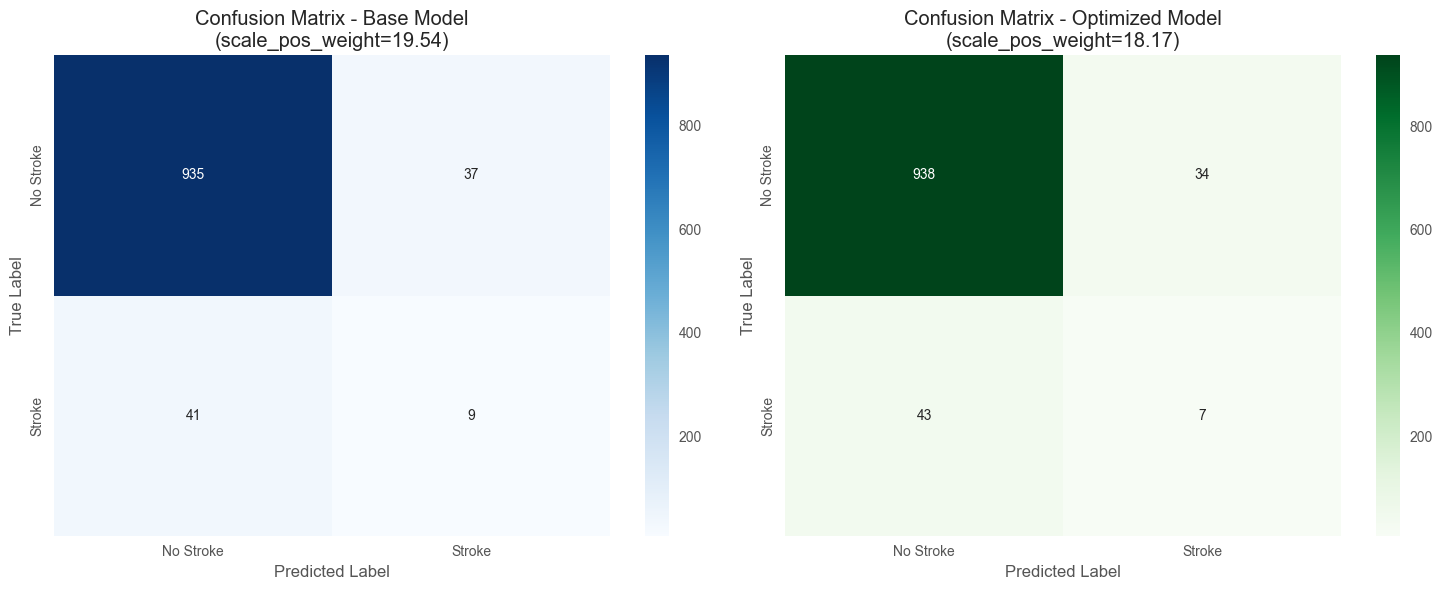

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

cm_base = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
axes[0].set_title(f'Confusion Matrix - Base Model\n(scale_pos_weight={pos_class_weight:.2f})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_opt = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
axes[1].set_title(f'Confusion Matrix - Optimized Model\n(scale_pos_weight={study.best_params["scale_pos_weight"]:.2f})')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

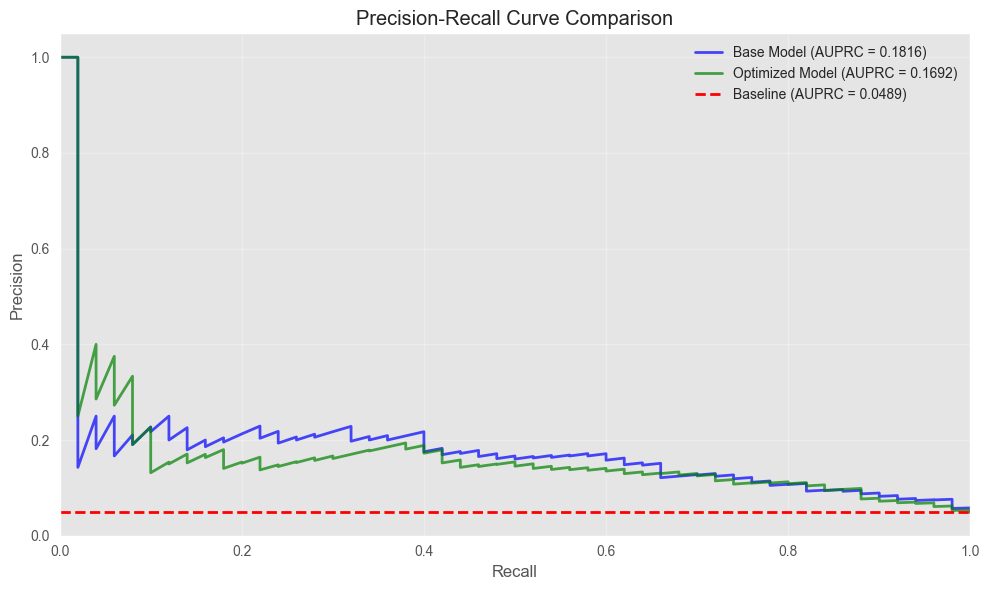

In [27]:
plt.figure(figsize=(10, 6))

precision_curve_base, recall_curve_base, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve_base, precision_curve_base, color='blue', lw=2, alpha=0.7,
         label=f'Base Model (AUPRC = {auprc:.4f})')

precision_curve_opt, recall_curve_opt, _ = precision_recall_curve(y_test, y_pred_proba_opt)
plt.plot(recall_curve_opt, precision_curve_opt, color='green', lw=2, alpha=0.7,
         label=f'Optimized Model (AUPRC = {auprc_opt:.4f})')

baseline = y_test.mean()
plt.axhline(y=baseline, color='red', lw=2, linestyle='--',
           label=f'Baseline (AUPRC = {baseline:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optuna Summary


In [28]:
print("Optuna Optimization Summary:")
print("="*70)
print(f"Number of trials: {len(study.trials)}")
print(f"Best trial: #{study.best_trial.number}")
print()
print("Parameter Values:")
print(f"  Calculated scale_pos_weight: {pos_class_weight:.4f}")
print(f"  Optimized scale_pos_weight:  {study.best_params['scale_pos_weight']:.4f}")
print(f"  Difference:                  {abs(study.best_params['scale_pos_weight'] - pos_class_weight):.4f}")
print()
print("Performance on Test Set:")
print(f"  Base Model AUPRC:      {auprc:.4f}")
print(f"  Optimized Model AUPRC: {auprc_opt:.4f}")
print(f"  Improvement:           {auprc_opt - auprc:.4f} ({((auprc_opt - auprc) / auprc * 100):.2f}%)")


Optuna Optimization Summary:
Number of trials: 50
Best trial: #32

Parameter Values:
  Calculated scale_pos_weight: 19.5427
  Optimized scale_pos_weight:  18.1742
  Difference:                  1.3685

Performance on Test Set:
  Base Model AUPRC:      0.1816
  Optimized Model AUPRC: 0.1692
  Improvement:           -0.0125 (-6.86%)


# Best Scaled Positive Weight Summary

In [30]:
print("Scale_Pos_Weight XGBoost Model Summary:")
print("="*50)
print(f"Dataset: Stroke Prediction ({X.shape[0]:,} samples, {X.shape[1]} features)")
print(f"Class Distribution: {(1-y.mean())*100:.1f}% No Stroke, {y.mean()*100:.1f}% Stroke")
print(f"Best Approach: Calculated scale_pos_weight")
print(f"Train/Test Split: {len(X_train):,} / {len(X_test):,}")
print(f"Scale_pos_weight: {pos_class_weight:.4f} (ratio of majority to minority)")
print()
print("Performance Metrics:")
print(f"  - AUPRC (PRIMARY): {auprc:.4f}")
print(f"  - Baseline AUPRC:  {y.mean():.4f}")
print(f"  - Accuracy:        {accuracy:.4f}")
print(f"  - Precision:       {precision:.4f}")
print(f"  - Recall:          {recall:.4f}")
print(f"  - F1-Score:        {f1:.4f}")
print(f"  - ROC-AUC:         {roc_auc:.4f}")


Scale_Pos_Weight XGBoost Model Summary:
Dataset: Stroke Prediction (5,110 samples, 15 features)
Class Distribution: 95.1% No Stroke, 4.9% Stroke
Best Approach: Calculated scale_pos_weight
Train/Test Split: 4,088 / 1,022
Scale_pos_weight: 19.5427 (ratio of majority to minority)

Performance Metrics:
  - AUPRC (PRIMARY): 0.1816
  - Baseline AUPRC:  0.0487
  - Accuracy:        0.9237
  - Precision:       0.1957
  - Recall:          0.1800
  - F1-Score:        0.1875
  - ROC-AUC:         0.8052
